In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [2]:
### READ DATA ###
df = pd.read_excel('./Folds5x2_pp.xlsx')
print(df.shape)
df.head()

(9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


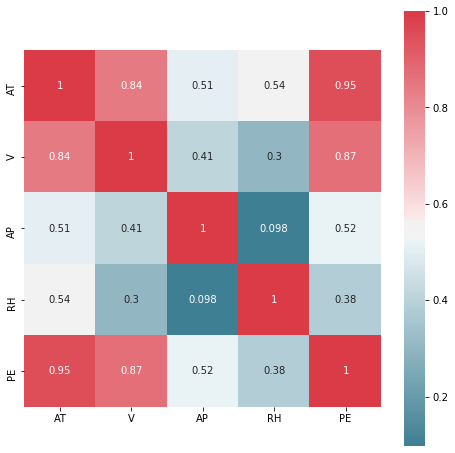

In [3]:
### PLOT CORRELATION MATRIX ###
plt.figure(figsize=(8,8))
train_size = int(df.shape[0]*0.8)
corr_matrix = df.iloc[:train_size,:].corr().abs()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)

In [4]:
### TRAIN TEST SPLIT ###
X, y = ['AT','V','AP','RH'], ['PE']
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size = 0.2, random_state = 42)

# GRADIENT BOOSTING FEATURE IMPORTANCES

In [5]:
### FIT GRADIENTBOOSTING ###
rf = GradientBoostingRegressor(n_estimators=100)
rf.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
### PREDICTION ERROR ON TEST DATA ###
mean_absolute_error(y_test, rf.predict(X_test))

2.9497468754355523

([<matplotlib.axis.XTick at 0x20fcf6f89e8>,
 <a list of 4 Text xticklabel objects>)

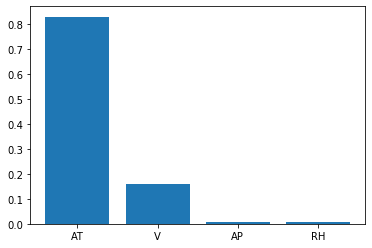

In [7]:
### FEATURE IMPORTANCES REPORT ###
plt.bar(range(X_train.shape[1]), rf.feature_importances_)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])

# PERMUTATION IMPORTANCE

In [8]:
### SCALE DATA FOR NN ###
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [9]:
### DEFINE NN STRUCTURE ###

inp = Input(shape=(scaled_train.shape[1],))
x = Dense(128, activation='relu')(inp)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

model = Model(inp, out)
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
### FIT NN ###
model.fit(scaled_train, (y_train - y_train.mean())/y_train.std() , epochs=100, batch_size=128 ,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 6s - loss: 0.2072
Epoch 2/100
 - 0s - loss: 0.0660
Epoch 3/100
 - 0s - loss: 0.0615
Epoch 4/100
 - 0s - loss: 0.0607
Epoch 5/100
 - 0s - loss: 0.0603
Epoch 6/100
 - 0s - loss: 0.0611
Epoch 7/100
 - 0s - loss: 0.0598
Epoch 8/100
 - 0s - loss: 0.0592
Epoch 9/100
 - 0s - loss: 0.0589
Epoch 10/100
 - 0s - loss: 0.0591
Epoch 11/100
 - 0s - loss: 0.0585
Epoch 12/100
 - 0s - loss: 0.0586
Epoch 13/100
 - 0s - loss: 0.0584
Epoch 14/100
 - 0s - loss: 0.0577
Epoch 15/100
 - 0s - loss: 0.0580
Epoch 16/100
 - 0s - loss: 0.0576
Epoch 17/100
 - 0s - loss: 0.0574
Epoch 18/100
 - 0s - loss: 0.0573
Epoch 19/100
 - 0s - loss: 0.0572
Epoch 20/100
 - 0s - loss: 0.0570
Epoch 21/100
 - 0s - loss: 0.0569
Epoch 22/100
 - 0s - loss: 0.0563
Epoch 23/100
 - 0s - loss: 0.0565
Epoch 24/100
 - 0s - loss: 0.0565
Epoch 25/100
 - 0s - loss: 0.0563
Epoch 26/100
 - 0s - loss: 0.0561
Epoch 27/100
 - 0s - loss: 0.0556
Epoch 28/100
 - 0s - loss: 0.0556
Epoch 29/

In [11]:
### PREDICTION ERROR ON TEST DATA ###
real_pred = model.predict(scaled_test).ravel() * y_train.std()[0] + y_train.mean()[0]
MAE = mean_absolute_error(y_test, model.predict(scaled_test).ravel() * y_train.std()[0] + y_train.mean()[0])
MAE

2.8853854392439344

In [12]:
### COMPUTE PERMUTATION AND SCORING ###
np.random.seed(33)

final_score = []
shuff_pred = []

for i,col in enumerate(X_test.columns):

    # shuffle column
    shuff_test = scaled_test.copy()
    shuff_test[:,i] = np.random.permutation(shuff_test[:,i])
    
    # compute score
    score = mean_absolute_error(y_test, model.predict(shuff_test).ravel() *y_train.std()[0]+y_train.mean()[0])
    shuff_pred.append(model.predict(shuff_test).ravel() *y_train.std()[0]+y_train.mean()[0])
    final_score.append(score)
    
final_score = np.asarray(final_score)

In [13]:
final_score

array([18.2158467 ,  5.27081073,  3.57609266,  3.81969698])

([<matplotlib.axis.XTick at 0x20fcf603b38>,
 <a list of 4 Text xticklabel objects>)

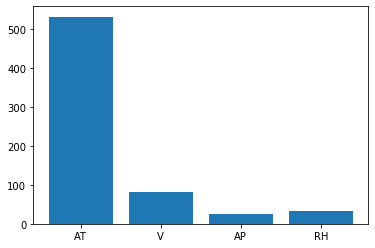

In [14]:
### PERMUTATION IMPORTANCE REPORT ###
plt.bar(range(X_train.shape[1]), (final_score - MAE)/MAE*100)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])

# EXPLAIN CASUALITY

In [15]:
### SIMULATE MEAN DIFFERENCE TEST AMONG PREDICTIONS ###
np.random.seed(33)
id_ = 0

merge_pred = np.hstack([shuff_pred[id_], real_pred])
observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
extreme_values = []
sample_d = []

for _ in range(10000):
    sample_mean = np.random.choice(merge_pred, size=shuff_pred[id_].shape[0]).mean()
    sample_diff = abs(sample_mean - merge_pred.mean())
    sample_d.append(sample_diff)
    extreme_values.append(sample_diff >= observed_diff)
    
np.sum(extreme_values)/10000

0.0219

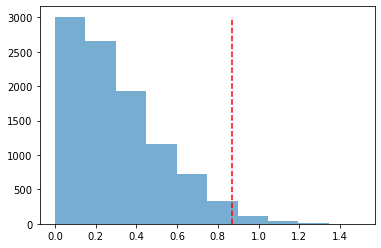

In [16]:
### PLOT MEAN DIFFERENCE DISTRIBUTIONS ###
y, x, _ = plt.hist(sample_d, alpha=0.6)
plt.vlines(observed_diff, 0,max(y), colors='red', linestyles='dashed')